# Image Captioning

## Data processing

In [2]:
from pathlib import Path
import torch

import numpy as np
import matplotlib.pyplot as plt

from torchvision.transforms import Resize, ToTensor, RandomRotation, Normalize

import torch.nn as nn
from torch import optim

from datetime import datetime as dt

The file captions.txt is a txt file where each row presents an image_name, the comment_number and the comment, since each image has 5 different captions

In [3]:
import os
import pandas as pd
import zipfile

zip_file_path = "./archive.zip"
extract_folder = "./archive"

# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#    zip_ref.extractall(extract_folder)

images_path = os.path.join(extract_folder, "flickr30k_images")
captions_path = "./captions.txt"

archive_df = pd.read_csv(
    captions_path,
    sep=",",
    header=None,
    names=["image_name", "caption_id", "caption"],
    skiprows=1,
)

"""
captions_df['image_path'] = captions_df['image_name'].apply(lambda x: os.path.join(images_path, x))
final_dataset = captions_df[['image_name', 'caption']]
final_dataset.to_csv('expanded_final_dataset.csv', index=False)
print(final_dataset.head)
"""

"\ncaptions_df['image_path'] = captions_df['image_name'].apply(lambda x: os.path.join(images_path, x))\nfinal_dataset = captions_df[['image_name', 'caption']]\nfinal_dataset.to_csv('expanded_final_dataset.csv', index=False)\nprint(final_dataset.head)\n"

## Vocabulary of words

In [4]:
!pip install nltk

In [5]:
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize

nltk.download("punkt")
nltk.download("punkt_tab")


class Vocabulary:
    def __init__(self, freq_threshold=5):
        self.freq_threshold = freq_threshold
        self.word2idx = {}
        self.idx2word = {}
        self.wheights = {}
        self.idx = 0

        self.add_word("<PAD>")  # to have all sentences of same target_len
        self.add_word("<SOS>")
        self.add_word("<EOS>")
        self.add_word("<UNK>")  # unknown word

        self.counter = None

    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def build_vocabulary(self, sentence_list):
        frequencies = Counter()
        for sentence in sentence_list:
            sentence = self.preprocess(sentence)
            words = word_tokenize(sentence.lower())
            frequencies.update(words)
        for word, freq in frequencies.items():
            if freq >= self.freq_threshold:
                self.add_word(word)
                self.wheights[word] = 1 / freq

        self.counter = frequencies

    def numericalize(self, sentence):
        sentence = self.preprocess(sentence)
        tokenized_text = word_tokenize(sentence.lower())
        return [
            self.word2idx.get(word, self.word2idx["<UNK>"]) for word in tokenized_text
        ]

    def one_hot_encode(self, word_or_idx):
        if isinstance(word_or_idx, str):  # If it's a word
            idx = self.word2idx.get(word_or_idx, self.word2idx["<UNK>"])
        elif isinstance(word_or_idx, int):  # If it's already an index
            idx = word_or_idx
        else:
            raise ValueError("Input must be a word (str) or an index (int).")
        one_hot_vector = torch.zeros(len(self.word2idx), dtype=torch.float32)
        one_hot_vector[idx] = 1.0
        return one_hot_vector

    def one_hot_encode_caption(self, caption):
        one_hot_vectors = [self.one_hot_encode(word) for word in caption]
        return torch.tensor(one_hot_vectors)

    def preprocess(self, sentence):
        return "".join([char for char in sentence if char.isalnum() or char.isspace()])

    def __len__(self):
        return len(self.word2idx)


# Probably captions need to be stored like this...


def caption_to_indices(vocab, caption):
    indices = [vocab.word2idx["<SOS>"]]
    for word in caption.split():
        indices.append(vocab.word2idx.get(word.lower(), "<UNK>"))
    indices.append(vocab.word2idx["<EOS>"])
    return indices


def pad_sequence(seq, target_len, pad_idx):
    if len(seq) < target_len:
        seq.extend(
            [pad_idx] * (target_len - len(seq))
        )  # padding at the end of sequence
    return seq[:target_len]


# caption_indices_list = [caption_to_indices(our_vocab, caption) for caption in captions_list]
# pad_idx = our_vocab.word2idx['<PAD>']
# caption_indices_padded = [pad_sequence(indices, target_len, pad_idx) for indices in caption_indices_list]


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jacob\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\jacob\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Example of usage of nltk and Vocabulary class

In [6]:
# how nltk works

sentence = "NLTK is a great toolkit for text processing!"
words = word_tokenize(sentence)
print(words)


# how a vocab works

example_captions = ["A man was riding a bike.", "A child is drawing a black horse."]

example_vocab = Vocabulary(freq_threshold=1)
example_vocab.build_vocabulary(example_captions)

print("Word -> Index:", example_vocab.word2idx)
print("Index -> Word:", example_vocab.idx2word)

caption = "A child is riding a horse"
numericalized_caption = example_vocab.numericalize(caption)
print("Numeric caption:", numericalized_caption)


['NLTK', 'is', 'a', 'great', 'toolkit', 'for', 'text', 'processing', '!']
Word -> Index: {'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'a': 4, 'man': 5, 'was': 6, 'riding': 7, 'bike': 8, 'child': 9, 'is': 10, 'drawing': 11, 'black': 12, 'horse': 13}
Index -> Word: {0: '<PAD>', 1: '<SOS>', 2: '<EOS>', 3: '<UNK>', 4: 'a', 5: 'man', 6: 'was', 7: 'riding', 8: 'bike', 9: 'child', 10: 'is', 11: 'drawing', 12: 'black', 13: 'horse'}
Numeric caption: [4, 9, 10, 7, 4, 13]


Now we will build our own vocabulary using all the captions from the dataset

In [7]:
captions_list = archive_df["caption"].tolist()
if os.path.isfile("our_vocab.pkl"):
    our_vocab = torch.load("our_vocab.pkl")
else:
    our_vocab = Vocabulary(freq_threshold=10)
    our_vocab.build_vocabulary(captions_list)
vocab_size = len(our_vocab)
print("Length of the vocabulary is: ", vocab_size)

Length of the vocabulary is:  5464


In [8]:
words_in_vocab = set(our_vocab.word2idx.keys())
words_in_wheights = set(our_vocab.wheights.keys())
unwheighted_words = words_in_vocab - words_in_wheights
print("Words without wheights: ", unwheighted_words)

our_vocab.wheights["<PAD>"] = 0
our_vocab.wheights["<SOS>"] = 0
our_vocab.wheights["<EOS>"] = 1 / len(our_vocab)
our_vocab.wheights["<UNK>"] = 1 / len(our_vocab)

class_weights = torch.tensor(
    [our_vocab.wheights[our_vocab.idx2word[i]] for i in range(len(our_vocab))]
)

print("Class wheights: ", class_weights[:30])

Words without wheights:  set()
Class wheights:  tensor([0.0000e+00, 0.0000e+00, 1.8302e-04, 1.8302e-04, 4.6206e-05, 7.5654e-05,
        1.5198e-03, 2.7619e-05, 1.9608e-02, 4.5025e-04, 7.5301e-04, 6.1504e-05,
        2.4771e-04, 6.4267e-04, 8.5390e-05, 1.5106e-03, 2.9138e-04, 1.1981e-05,
        1.5878e-05, 2.5381e-03, 7.5884e-05, 4.0323e-03, 4.9515e-05, 2.1268e-04,
        3.3156e-04, 7.7519e-04, 1.0526e-02, 1.0529e-04, 1.9153e-04, 1.0616e-03])


We now define the maximum length an output caption could be

In [9]:
max_caption_length = max([len(caption.split()) for caption in captions_list])
target_len = 15
print("The maximum length a caption produced by our model could reach is ", target_len)

"""
#To find which caption has max length
lengths = np.array([len(caption.split()) for caption in captions_list])
max_length_idx = np.argmax(lengths)
max_caption = captions_list[max_length_idx]
print(max_caption)
print("Number of words:", lengths[max_length_idx])
"""

The maximum length a caption produced by our model could reach is  15


'\n#To find which caption has max length\nlengths = np.array([len(caption.split()) for caption in captions_list])\nmax_length_idx = np.argmax(lengths)\nmax_caption = captions_list[max_length_idx]\nprint(max_caption)\nprint("Number of words:", lengths[max_length_idx])\n'

Convert captions to vectors of indexes

In [10]:
def caption_to_padded_indices(vocab, caption, target_len):
    indices = []  # [vocab.word2idx["<SOS>"]]

    for word in caption.split():
        indices.append(vocab.word2idx.get(word.lower(), vocab.word2idx["<UNK>"]))
    indices.append(vocab.word2idx["<EOS>"])
    pad_idx = vocab.word2idx["<PAD>"]
    if len(indices) < target_len:
        indices.extend([pad_idx] * (target_len - len(indices)))
    else:
        indices = indices[:target_len]
    return torch.tensor(indices)


# caption_indices_padded = [
#     caption_to_padded_indices(our_vocab, caption, target_len)
#     for caption in captions_list
# ]

# print(captions_list[0])
# print(caption_indices_padded[0])
# print(caption_indices_padded[0].shape)

print(caption_to_padded_indices(our_vocab, "two men are standing", target_len))

tensor([ 4, 27, 22, 30,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])


In [11]:
def caption_to_one_hot_matrix(vocab, caption, target_len):
    """
    Convert a caption (string) to a one-hot encoded matrix.

    Args:
    - vocab (Vocabulary): The vocabulary object.
    - caption (str): The caption string.
    - target_len (int): The target length for padding the sequence.

    Returns:
    - torch.Tensor: A matrix of shape (target_len, vocab_size) where each row is a one-hot encoded vector.
    """
    words = caption.split()
    indices = [vocab.word2idx["<SOS>"]]
    for word in words:
        idx = vocab.word2idx.get(word.lower(), vocab.word2idx["<UNK>"])
        indices.append(idx)
    indices.append(vocab.word2idx["<EOS>"])
    pad_idx = vocab.word2idx["<PAD>"]
    if len(indices) < target_len:
        indices.extend([pad_idx] * (target_len - len(indices)))
    else:
        indices = indices[:target_len]

    one_hot_matrix = torch.zeros((target_len, len(vocab.word2idx)), dtype=torch.float32)
    for i, idx in enumerate(indices):
        one_hot_matrix[i, idx] = 1.0

    return one_hot_matrix


print(captions_list[0])
print(caption_to_one_hot_matrix(our_vocab, captions_list[0], target_len).shape)


Two young guys with shaggy hair look at their hands while hanging out in the yard .
torch.Size([15, 5464])


## Division into training, validation and test set

Since the pictures repeat themselves with different captions, we need to make sure that in the train, validation and test sets there are different images regardless, otherwise validation and testing wouldn't be done on new and unseen data.

In [12]:
from torch.utils.data import random_split

image_capidx_df = pd.DataFrame(
    {
        "image_name": archive_df["image_name"],
        "caption": archive_df["caption"],
    }
)
print(image_capidx_df.head)

unique_images = image_capidx_df["image_name"].unique()
num_images = len(unique_images)
unique_images_df = pd.DataFrame(unique_images, columns=["image_name"])

np.random.seed(42)  # for reproducibility
np.random.shuffle(unique_images)

train_images, val_images, test_images = random_split(range(num_images), [0.7, 0.2, 0.1])

train_image_names = unique_images_df.iloc[train_images.indices].image_name.tolist()
val_image_names = unique_images_df.iloc[val_images.indices].image_name.tolist()
test_image_names = unique_images_df.iloc[test_images.indices].image_name.tolist()

train_df = image_capidx_df[
    image_capidx_df["image_name"].isin(train_image_names)
].reset_index(drop=True)

val_df = (
    image_capidx_df[image_capidx_df["image_name"].isin(val_image_names)]
    .groupby("image_name", as_index=False)
    .agg({"caption": lambda x: x.sample(1).values[0]})  # Randomly select one caption
).reset_index(drop=True)

test_df = (
    image_capidx_df[image_capidx_df["image_name"].isin(test_image_names)]
    .groupby("image_name", as_index=False)
    .agg({"caption": lambda x: x.sample(1).values[0]})  # Randomly select one caption
).reset_index(drop=True)

print(f"Train dataset size:\t {train_df.shape[0]}")
print(f"Validation dataset size: {val_df.shape[0]}")  # only contains unique images
print(f"Test dataset size:\t {test_df.shape[0]}")  # only contains unique images

<bound method NDFrame.head of             image_name                                            caption
0       1000092795.jpg  Two young guys with shaggy hair look at their ...
1       1000092795.jpg  Two young  White males are outside near many b...
2       1000092795.jpg   Two men in green shirts are standing in a yard .
3       1000092795.jpg       A man in a blue shirt standing in a garden .
4       1000092795.jpg            Two friends enjoy time spent together .
...                ...                                                ...
158910   998845445.jpg  A man in shorts and a Hawaiian shirt leans ove...
158911   998845445.jpg  A young man hanging over the side of a boat  w...
158912   998845445.jpg  A man is leaning off of the side of a blue and...
158913   998845445.jpg  A man riding a small boat in a harbor  with fo...
158914   998845445.jpg  A man on a moored blue and white boat with hil...

[158915 rows x 2 columns]>


Train dataset size:	 111245
Validation dataset size: 6356
Test dataset size:	 3178


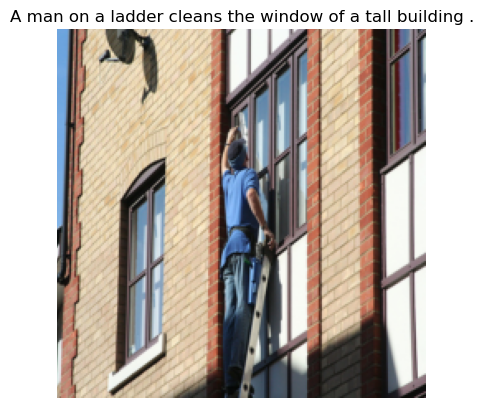

In [13]:
from itertools import chain

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


class Flickr30kImages(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_name = self.dataframe.iloc[idx]["image_name"]
        caption = self.dataframe.iloc[idx]["caption"]
        tensor_captioning_indices = caption_to_padded_indices(
            our_vocab, caption, target_len
        )

        image_path = os.path.join(images_path, image_name)
        image = Image.open(image_path)

        if self.transform:
            image = self.transform(image)

        return image, tensor_captioning_indices

    def get_caption(self, idx):
        return self.dataframe.iloc[idx]["caption"]


transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

train_dataset = Flickr30kImages(dataframe=train_df, transform=transform)
dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)


def display_image(index, dataset):
    if index >= len(dataset):
        raise ValueError(f"Index is out of bounds for the dataset")
    image, _ = dataset[index]
    image = image.permute(1, 2, 0).detach().numpy()
    # image = (image * 255).astype('uint8')
    height, width, _ = image.shape
    plt.xlim(0, width)
    plt.ylim(height, 0)
    plt.imshow(image)
    plt.title(dataset.get_caption(index))
    plt.axis("off")
    plt.show()


display_image(2, train_dataset)

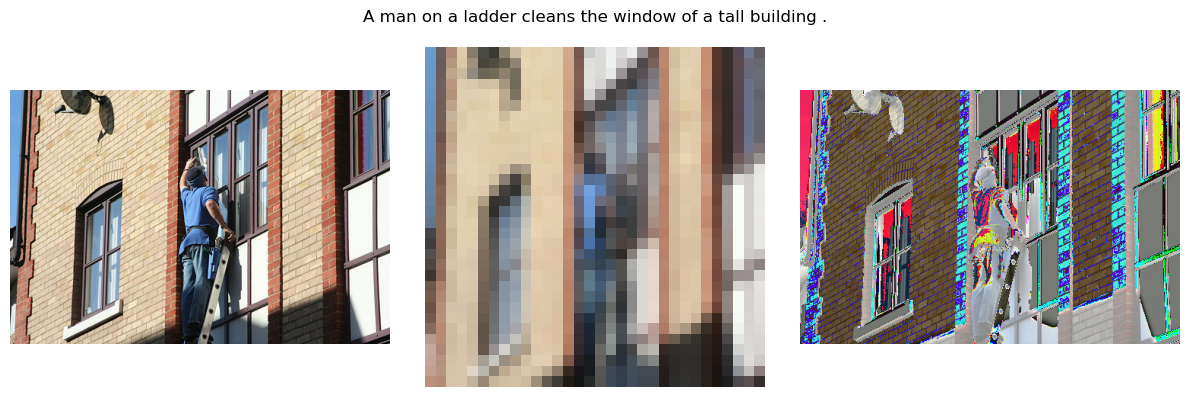

In [14]:
def compare_transforms(transformations, index_image, vocab):
    if not all(isinstance(transf, Dataset) for transf in transformations):
        raise TypeError(
            "All elements in the `transformations` list need to be of type Dataset"
        )

    num_tr = len(transformations)
    fig, axes = plt.subplots(1, num_tr, figsize=(num_tr * 4, 4))

    if num_tr == 1:
        axes = [axes]

    image, _ = transformations[0][index_image]

    for counter, (axis, transf) in enumerate(zip(axes, transformations)):
        image, _ = transf[index_image]
        if isinstance(image, torch.Tensor):
            image = image.permute(1, 2, 0).detach().numpy()
            if image.shape[2] == 3:
                if image.max() <= 1.0:
                    image = (image * 255).astype("uint8")
        axis.imshow(image)
        axis.axis("off")

    plt.suptitle(transformations[0].get_caption(index_image))
    plt.tight_layout()
    plt.show()


example_dataset1 = Flickr30kImages(train_df)
img_size = 32
transform = transforms.Compose([Resize(size=(img_size, img_size)), ToTensor()])
example_dataset2 = Flickr30kImages(train_df, transform)
transform = transforms.Compose([ToTensor(), Normalize(0.5, 1, inplace=True)])
example_dataset3 = Flickr30kImages(train_df, transform)

ex_dataset = [example_dataset1, example_dataset2, example_dataset3]
compare_transforms(ex_dataset, 2, our_vocab)

In [15]:
example_dataset1[0]

(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x333>,
 tensor([86, 17, 31, 33, 34, 87, 88, 69, 30, 52, 89, 87, 90, 91, 31]))

## NN model

In [17]:
from transformers import AutoProcessor, AutoModelForCausalLM
import requests
from PIL import Image
import matplotlib.pyplot as plt
import torch

processor = AutoProcessor.from_pretrained("microsoft/git-base-coco")
model = AutoModelForCausalLM.from_pretrained("microsoft/git-base-coco")

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# pixel_values = processor(images=image, return_tensors="pt").pixel_values.to(device)
# generated_ids = model.generate(pixel_values=pixel_values, max_length=80)
# generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

# print(generated_caption)

GitForCausalLM(
  (git): GitModel(
    (embeddings): GitEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(1024, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (image_encoder): GitVisionModel(
      (vision_model): GitVisionTransformer(
        (embeddings): GitVisionEmbeddings(
          (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
          (position_embedding): Embedding(197, 768)
        )
        (pre_layrnorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (encoder): GitVisionEncoder(
          (layers): ModuleList(
            (0-11): 12 x GitVisionEncoderLayer(
              (self_attn): GitVisionAttention(
                (k_proj): Linear(in_features=768, out_features=768, bias=True)
                (v_proj): Linear(in_features=768, out_features=768, bias=True)
             

## Training

In [18]:
class Flickr30kImages_names(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_name = self.dataframe.iloc[idx]["image_name"]
        caption = self.dataframe.iloc[idx]["caption"]
        tensor_captioning_indices = caption_to_padded_indices(
            our_vocab, caption, target_len
        )

        image_path = os.path.join(images_path, image_name)
        image = Image.open(image_path)

        if self.transform:
            image = self.transform(image)

        return image, image_name

    def get_caption(self, idx):
        return self.dataframe.iloc[idx]["caption"]

    def get_image_name(self, idx):
        return self.dataframe.iloc[idx]["image_name"]

In [19]:
def logits_to_captions(logits, vocab):
    if len(logits.shape) == 2:
        _, predicted_indices = logits.max(dim=-1)
    else:
        predicted_indices = logits
    caption = []
    for idx in predicted_indices:
        word = vocab.idx2word[idx.item()]
        if word == "<EOS>":
            break
        if word != "<SOS>":
            caption.append(word)
    caption_string = " ".join(caption)
    return caption_string

In [22]:
from torchvision.transforms import Resize, ToTensor, Normalize, GaussianBlur

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]


if True:
    test_dataset = Flickr30kImages_names(dataframe=test_df, transform=None)
    test_loader = DataLoader(test_dataset, batch_size=1, num_workers=0)

    print(f"Starting testing loop with {len(test_loader)} batches")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print(device)
    model.to(device)

    test_predicted_dict = {}
    with torch.no_grad():
        for i, (x, y) in enumerate(test_dataset):
            print(f"Batch {i+1}/{len(test_loader)}")

            pixel_values = processor(images=x, return_tensors="pt").pixel_values.to(
                device
            )

            # plt.imshow(pixel_values[0].permute(1, 2, 0).cpu().numpy())
            generated_ids = model.generate(pixel_values=pixel_values, max_length=80)
            generated_caption = processor.batch_decode(
                generated_ids, skip_special_tokens=True
            )

            for image_name, caption in zip(y, generated_caption):
                print(caption)
                test_predicted_dict[image_name] = caption

    torch.save(test_predicted_dict, "jbtest.pkl")
else:
    test_predicted_dict = torch.load("test_predicted_dict_GRU.pkl")

Starting testing loop with 3178 batches
cpu
Batch 1/3178
a man is holding a stuffed animal
Batch 2/3178


KeyboardInterrupt: 

In [126]:
# test_predicted_dict = imgname -> caption
# filtered_ground_truth_dict = imgname -> [caption]

if False:
    test_ground_truth_dict = {}
    for img_name in test_predicted_dict.keys():
        captions_list = image_capidx_df[image_capidx_df["image_name"] == img_name][
            "caption"
        ].tolist()
        test_ground_truth_dict[img_name] = []

        for caption in captions_list:
            capt = caption.split(" ")
            if not len(capt) <= target_len - 1:  # -1 because of <EOS>
                capt = capt[:target_len]
            test_ground_truth_dict[img_name].append(" ".join(capt))

    torch.save(test_ground_truth_dict, "test_ground_truth_dict.pkl")
else:
    test_ground_truth_dict = torch.load("test_ground_truth_dict.pkl")

In [127]:
from pycocoevalcap.cider.cider import Cider

cider_scorer = Cider()
cider_score, _ = cider_scorer.compute_score(test_ground_truth_dict, test_predicted_dict)
print(f"CIDEr score for test dataset: {cider_score}")

CIDEr score for test dataset: 0.07245224784931084


In [128]:
#!pip install evaluate

import evaluate

meteor = evaluate.load("meteor")

predictions = [test_predicted_dict[img_name][0] for img_name in test_predicted_dict]
references = [
    test_ground_truth_dict[img_name][0] for img_name in test_ground_truth_dict
]

meteor_score = meteor.compute(predictions=predictions, references=references)

print(f"METEOR score: {meteor_score['meteor']}")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jacob\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\jacob\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\jacob\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


METEOR score: 0.041252543820654186


In [129]:
#!pip install rouge_score

from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)

rouge_1_scores = []
rouge_2_scores = []
rouge_l_scores = []

for image_name in test_predicted_dict.keys():
    references = test_ground_truth_dict[image_name]
    prediction = test_predicted_dict[image_name][0]
    scores = scorer.score(references[0], prediction)
    rouge_1_scores.append(scores["rouge1"].fmeasure)
    rouge_2_scores.append(scores["rouge2"].fmeasure)
    rouge_l_scores.append(scores["rougeL"].fmeasure)

average_rouge_1 = sum(rouge_1_scores) / len(rouge_1_scores)
average_rouge_2 = sum(rouge_2_scores) / len(rouge_2_scores)
average_rouge_l = sum(rouge_l_scores) / len(rouge_l_scores)

print(f"Average ROUGE-1 Score: {average_rouge_1}")
print(f"Average ROUGE-2 Score: {average_rouge_2}")
print(f"Average ROUGE-L Score: {average_rouge_l}")


Average ROUGE-1 Score: 0.0746393472890739
Average ROUGE-2 Score: 0.004331233616033031
Average ROUGE-L Score: 0.07184172958961231
